# Napa County Model

Build the model for Napa County California. The goal of the model will be to predict the total burn area of wildfires in Napa County for a given month

In [1]:
import pandas as pd
import numpy as np
from helper_functions import dataset_formatter
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

Read in the data and prep Napa County

In [2]:
fire_data = pd.read_csv("./Data/clean_fire_data.csv", parse_dates=["MONTH"])
fire_data['FIPS_CODE'] = fire_data['FIPS_CODE'].astype(str).str.zfill(5)
fire_data['STATE_CODE'] = fire_data['FIPS_CODE'].str.slice(0, 2)

weather_data = pd.read_csv("./Data/cleaned_weather_data.csv", parse_dates=['MONTH'])
weather_data['STATE_CODE'] = weather_data['STATE_CODE'].astype(str).str.zfill(2)

min_month = min(fire_data['MONTH'])
max_month = max(fire_data['MONTH'])

indx = pd.date_range(start=min_month, end=max_month, freq='MS')

complete_data = pd.DataFrame(np.dstack(np.meshgrid(np.unique(fire_data['FIPS_CODE']), indx)).reshape(-1, 2), 
                             columns=['FIPS_CODE', 'MONTH'])

complete_data['MONTH'] = pd.to_datetime(complete_data['MONTH'])

fips_data = fire_data.groupby(by='FIPS_CODE').agg({'COUNTY_AREA': min, 'STATE_CODE': min}).reset_index()

full_data = pd.merge(complete_data, fire_data[['FIPS_CODE', 'MONTH', 'TOTAL_BURN_AREA']], 
                     how='left', on=['FIPS_CODE', 'MONTH']).fillna(0)

full_data = pd.merge(full_data, fips_data, how='inner', on=['FIPS_CODE'])

final_data = pd.merge(full_data, weather_data, how='inner', on=['MONTH', 'STATE_CODE'])

final_data['MONTH_VALUE'] = final_data['MONTH'].dt.month

final_data.sort_values(by=['FIPS_CODE', 'MONTH'], inplace=True)

cols = ["TOTAL_BURN_AREA", "PRCP", "TMIN", "TMAX"]
lags = [1, 2, 3, 4, 5, 6, 11, 12, 13, 23, 24, 25]
for c in cols:
    for l in lags:
        final_data[f"{c}_lag{l}"] = final_data.groupby('FIPS_CODE')[c].shift(l)

final_data.dropna(inplace=True)

In [3]:
train_data = final_data.groupby(by='FIPS_CODE').apply(lambda x: x[:-12])
test_data = final_data.groupby(by='FIPS_CODE').apply(lambda x: x[-12:])

In [5]:
final_data['STATE'].value_counts()

CO    18837
CA    17342
MT    16744
ID    13156
WA    11661
OR    10764
NM     9568
UT     8671
WY     6877
NV     4784
AZ     4485
Name: STATE, dtype: int64

In [6]:
model_columns = ['TOTAL_BURN_AREA', 'FIPS_CODE', 'COUNTY_AREA', 'STATE',
                 'PRCP', 'TMAX', 'TOTAL_BURN_AREA_lag1',
                 'TOTAL_BURN_AREA_lag2', 'TOTAL_BURN_AREA_lag3',
                 'TOTAL_BURN_AREA_lag11',
                 'TOTAL_BURN_AREA_lag12', 'TOTAL_BURN_AREA_lag13',
                 'TOTAL_BURN_AREA_lag23', 'TOTAL_BURN_AREA_lag24',
                 'TOTAL_BURN_AREA_lag25',
                 'PRCP_lag4', 'PRCP_lag5', 'PRCP_lag12',
                 'PRCP_lag23', 'PRCP_lag25',
                 'TMIN_lag6',
                 'TMIN_lag11', 'TMIN_lag12', 'TMIN_lag23', 'TMIN_lag24',
                 'TMAX_lag4',
                 'TMAX_lag5', 'TMAX_lag6', 'TMAX_lag11', 'TMAX_lag12',
                 'TMAX_lag23', 'TMAX_lag24']

model_data = final_data[model_columns]

train_data = model_data.groupby(by='FIPS_CODE').apply(lambda x: x[:-12])
test_data = model_data.groupby(by='FIPS_CODE').apply(lambda x: x[-12:])

X_Train, y_train = train_data.drop(['TOTAL_BURN_AREA'], axis=1), train_data['TOTAL_BURN_AREA']
X_Test, y_test =  test_data.drop(['TOTAL_BURN_AREA'], axis=1), test_data['TOTAL_BURN_AREA']

In [10]:
final_data.groupby(by='FIPS_CODE').apply(lambda x: x[:-12])['MONTH']

FIPS_CODE        
04001      375      1994-02-01
           390      1994-03-01
           405      1994-04-01
           420      1994-05-01
           435      1994-06-01
                       ...    
56045      132795   2017-08-01
           132818   2017-09-01
           132841   2017-10-01
           132864   2017-11-01
           132887   2017-12-01
Name: MONTH, Length: 117957, dtype: datetime64[ns]

In [11]:
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, median_absolute_error

In [12]:
train_pool = Pool(X_Train, label=y_train, cat_features=['FIPS_CODE', 'STATE'])

In [13]:
model = CatBoostRegressor(iterations=1000, verbose=0, has_time=True, random_seed=42, 
                          min_data_in_leaf=10, max_depth=5).fit(train_pool)

In [12]:
# model.get_all_params()

In [48]:
train_preds = model.predict(X_Train)
test_preds = model.predict(X_Test)

In [49]:
print(np.sqrt(mean_squared_error(train_preds, y_train)))
print(mean_absolute_percentage_error(train_preds, y_train))
print(median_absolute_error(train_preds, y_train))

5209.476235459834
2.1519768715470677
114.88793495466075


In [50]:
print(np.sqrt(mean_squared_error(test_preds, y_test)))
print(mean_absolute_percentage_error(test_preds, y_test))
print(median_absolute_error(test_preds, y_test))

12213.95324277882
7.431136812958053
134.6866424146106


In [51]:
# print(median_absolute_error(test_preds, y_test))
# print(mean_absolute_percentage_error(test_preds, y_test))

In [52]:
pd.DataFrame(zip(X_Train.columns, model.feature_importances_), 
             columns=['Column', 'Importance']).sort_values('Importance', ascending=False)

,Column,Importance
4,TMAX,9.476091
8,TOTAL_BURN_AREA_lag11,9.042018
5,TOTAL_BURN_AREA_lag1,8.415740
9,TOTAL_BURN_AREA_lag12,7.410818
1,COUNTY_AREA,5.017180
11,TOTAL_BURN_AREA_lag23,4.648729
12,TOTAL_BURN_AREA_lag24,4.110648
3,PRCP,3.604639
26,TMAX_lag6,3.437551
10,TOTAL_BURN_AREA_lag13,3.166168


In [53]:
import shap
shap.initjs()

In [54]:
samps = X_Train.sample(50000)

explainer = shap.TreeExplainer(model)
shap_vals = explainer(samps)

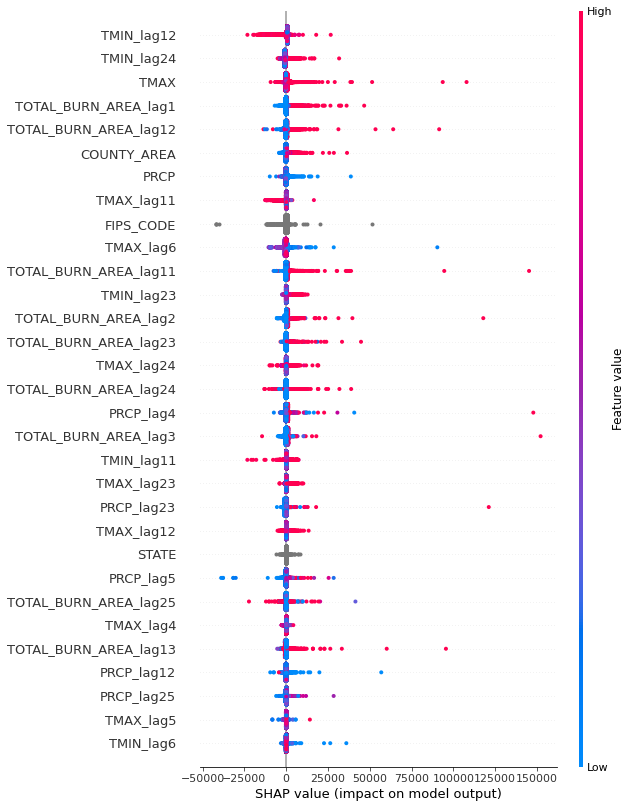

In [55]:
fig = shap.summary_plot(shap_values=shap_vals, features=samps, max_display=40)

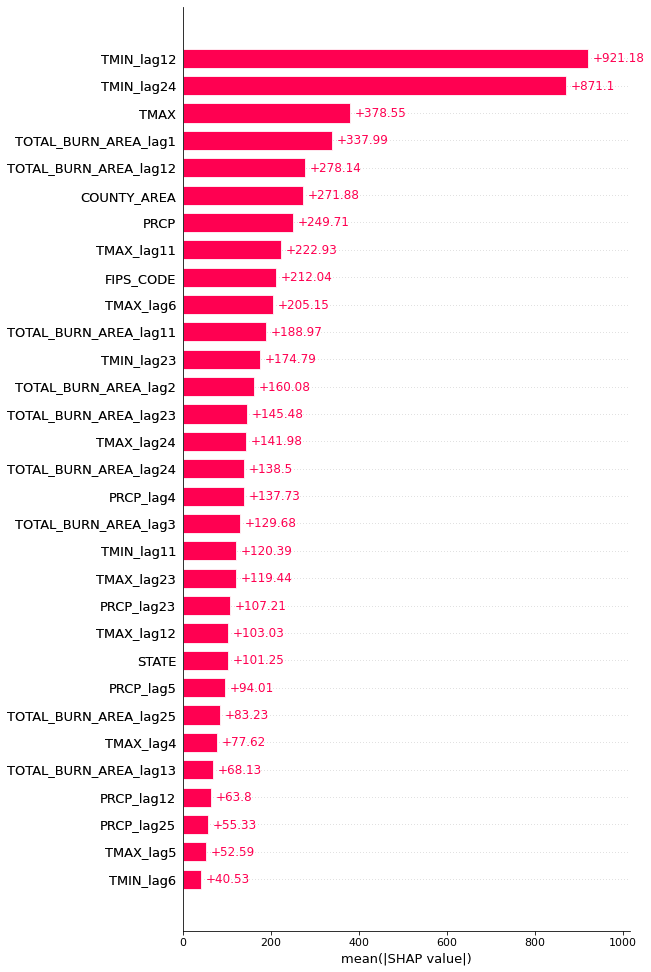

In [56]:
shap.plots.bar(shap_vals, max_display=31)

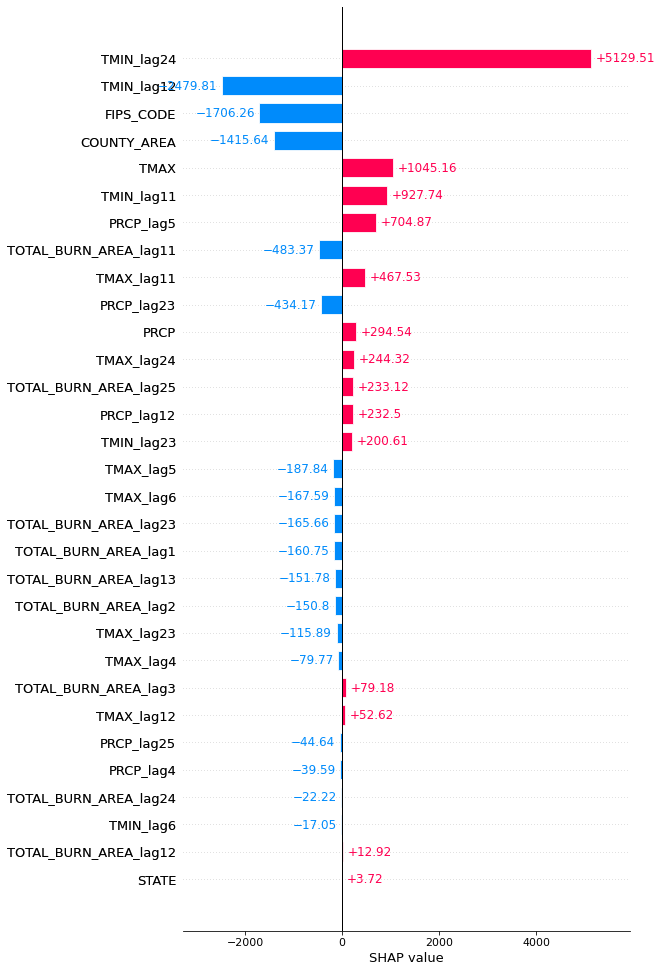

In [57]:
sample = final_data.iloc[np.where((final_data['FIPS_CODE'] == '06055') & 
                                  (final_data['MONTH'] == '2015-07-01'))][model_columns].drop(['TOTAL_BURN_AREA'], axis=1)
sample

exp = explainer(sample)

shap.plots.bar(exp[0], max_display=31)

In [58]:
fcst_train = X_Train.copy().reset_index(drop=True)
fcst_test = X_Test.copy().reset_index(drop=True)

fcst_train['Preds'] = np.clip(train_preds, a_min=0, a_max=None)
fcst_test['Preds'] = np.clip(test_preds, a_min=0, a_max=None)

napa_train_preds = fcst_train[fcst_train['FIPS_CODE'] == '06055']['Preds']
elko_train_preds = fcst_train[fcst_train['FIPS_CODE'] == '32007']['Preds']
napa_test_preds = fcst_test[fcst_test['FIPS_CODE'] == '06055']['Preds']
elko_test_preds = fcst_test[fcst_test['FIPS_CODE'] == '32007']['Preds']

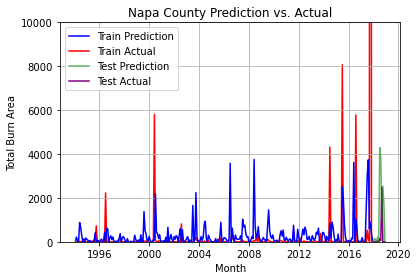

In [73]:
plt.plot(final_data.loc[final_data['FIPS_CODE'] == '06055']['MONTH'][:-12], napa_train_preds.values, color='blue', zorder=2, 
        label='Train Prediction')
plt.plot(final_data.loc[final_data['FIPS_CODE'] == '06055']['MONTH'][:-12], 
        final_data.loc[final_data['FIPS_CODE'] == '06055']['TOTAL_BURN_AREA'][:-12], color='red', zorder=1, 
        label='Train Actual')

plt.plot(final_data.loc[final_data['FIPS_CODE'] == '06055']['MONTH'][-12:], napa_test_preds.values, color='green', zorder=2,
        label='Test Prediction', alpha=0.6)
plt.plot(final_data.loc[final_data['FIPS_CODE'] == '06055']['MONTH'][-12:], 
        final_data.loc[final_data['FIPS_CODE'] == '06055']['TOTAL_BURN_AREA'][-12:], color='purple', zorder=1,
        label='Test Actual')
plt.grid()
plt.title("Napa County Prediction vs. Actual")
plt.legend()
plt.ylabel("Total Burn Area")
plt.xlabel('Month')
plt.tight_layout()
plt.ylim(0, 10000)
plt.savefig("./img/NapaPredPlot.png")
plt.show()

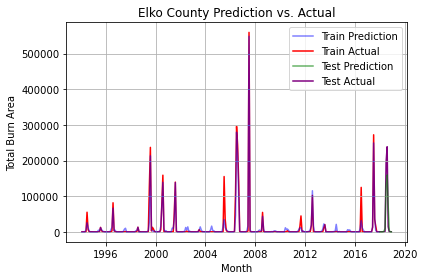

In [72]:
plt.plot(final_data.loc[final_data['FIPS_CODE'] == '32007']['MONTH'][:-12], elko_train_preds.values, color='blue', zorder=2, 
        label='Train Prediction', alpha=0.5)
plt.plot(final_data.loc[final_data['FIPS_CODE'] == '32007']['MONTH'][:-12], 
        final_data.loc[final_data['FIPS_CODE'] == '32007']['TOTAL_BURN_AREA'][:-12], color='red', zorder=1, 
        label='Train Actual', alpha=1)

plt.plot(final_data.loc[final_data['FIPS_CODE'] == '32007']['MONTH'][-12:], elko_test_preds.values, color='green', zorder=2,
        label='Test Prediction', alpha=0.6)
plt.plot(final_data.loc[final_data['FIPS_CODE'] == '32007']['MONTH'][-12:], 
        final_data.loc[final_data['FIPS_CODE'] == '32007']['TOTAL_BURN_AREA'][-12:], color='purple', zorder=1,
        label='Test Actual')
plt.grid()
plt.title("Elko County Prediction vs. Actual")
plt.legend()
plt.ylabel("Total Burn Area")
plt.xlabel('Month')
plt.tight_layout()
plt.savefig("./img/ElkoPredPlot.png")
# plt.ylim(0, 150000)
plt.show()